# Tutorial: QUESTS

This tutorial introduces the method QUESTS: Quick Uncertainty and Entropy via STructural Similarity for atomistic simulations. Google Colab created by [Daniel Schwalbe-Koda](https://dskoda.com/), based on the [original code](https://github.com/dskoda/quests).

Preprint: D. Schwalbe-Koda et al. Information theory unifies atomistic machine learning, uncertainty quantification, and materials thermodynamics. *arXiv:2404.12367* (2024). [Link](https://doi.org/10.48550/arXiv.2404.12367)

In [1]:
!pip3 install quests
!pip3 install quests[gpu]
!git clone https://github.com/dskoda/2024-UChicago-AI-Science.git

fatal: destination path '2024-UChicago-AI-Science' already exists and is not an empty directory.


In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from ase.io import read
from quests.descriptor import get_descriptors
from quests.gpu.entropy import perfect_entropy, delta_entropy
# from quests.entropy import perfect_entropy, diversity, delta_entropy

import matplotlib.pyplot as plt
import seaborn as sns

DATA_ROOT = "2024-UChicago-AI-Science"

# rMD-17 (Fig 3a)

In [3]:
molecules = ["azobenzene", "benzene"]
num_points = [1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4]

In [4]:
h = 0.015
batch_size = 10000

rmd17_df = []
for mol in molecules:
    dset = read(f"{DATA_ROOT}/rmd17/{mol}.xyz", index=":")

    for num in tqdm(num_points):
        inds = np.random.choice(np.arange(len(dset)), size=int(num), replace=False)
        _dset = [dset[i] for i in inds]

        x = get_descriptors(_dset, k=32, cutoff=5.0)
        x = torch.tensor(x, device="cuda")
        H = perfect_entropy(x, h=h, batch_size=batch_size)

        rmd17_df.append({
            "mol": mol,
            "num_points": num,
            "entropy": H,
        })

rmd17_df = pd.DataFrame(rmd17_df)

100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


In [5]:
# Alternatively, if the execution is taking too long, just load it from the results
# rmd17_df = pd.read_csv("2024-UChicago-AI-Science/results/rmd17.csv")

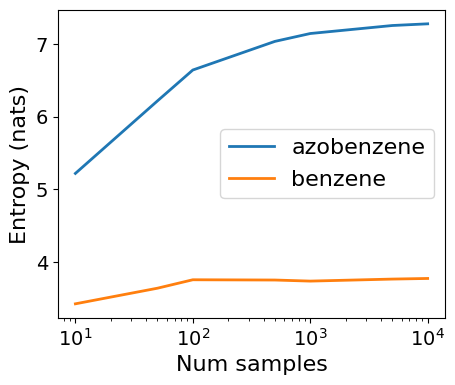

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))

for mol in molecules:
    rows = rmd17_df.loc[rmd17_df['mol'] == mol].sort_values(by='num_points')
    ax.plot(rows['num_points'], rows['entropy'], label=mol, linewidth=2.0)

ax.tick_params(axis='both', labelsize=14)
ax.set_xscale("log")

ax.legend(fontsize=16)

ax.set_xlabel("Num samples", fontsize=16)
ax.set_ylabel("Entropy (nats)", fontsize=16)

plt.show()

# GAP-20 (Fig 3c)

In [7]:
gap20_systems = ["Graphene", "Graphite", "Graphite_Layer_Sep", "Nanotubes"]

In [8]:
h = 0.015
batch_size = 10000

gap20_df = []
for system in tqdm(gap20_systems):
    dset = read(f"{DATA_ROOT}/gap20/{system}.xyz", index=":")

    x = get_descriptors(dset, k=32, cutoff=5.0)
    x = torch.tensor(x, device="cuda")
    H = perfect_entropy(x, h=h, batch_size=batch_size)

    gap20_df.append({
        "system": system,
        "entropy": H.item(),
        "log n": np.log(len(x)),
    })

gap20_df = pd.DataFrame(gap20_df)

100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


In [9]:
# Alternatively, if the execution is taking too long, just load it from the results
# gap20_df = pd.read_csv(f"{DATA_ROOT}/results/gap20.csv")

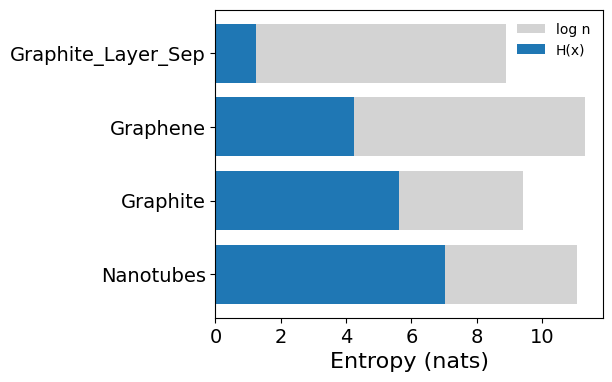

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

gap20_df = gap20_df.sort_values(by='entropy', ascending=False)

ax.barh(gap20_df['system'], gap20_df['log n'], color='lightgrey', label="log n")
ax.barh(gap20_df['system'], gap20_df['entropy'], label="H(x)")

ax.tick_params(axis='both', labelsize=14)

ax.set_xlabel("Entropy (nats)", fontsize=16)

ax.legend(frameon=False)

plt.show()

# Information gap of Graphene and Graphite (Fig 3d)

In [11]:
k, cutoff = 32, 5.0

infogap_df = []
for system in ['Graphene', 'Graphite']:
    dset = read(f"{DATA_ROOT}/gap20/{system}.xyz", index=":")

    x = get_descriptors(dset, k=k, cutoff=cutoff)
    x = torch.tensor(x, device="cuda")
    H = perfect_entropy(x, h=h, batch_size=batch_size)

    for frac in tqdm(np.linspace(0.2, 1.0, 9)):
        if frac == 1.0:
            H_frac, dH = H, 0.0

        else:
            inds = np.random.choice(np.arange(len(dset)), size=int(frac * len(dset)), replace=False)
            _dset = [dset[i] for i in inds]

            x = get_descriptors(_dset, k=k, cutoff=cutoff)
            x = torch.tensor(x, device="cuda")
            H_frac = perfect_entropy(x, h=h, batch_size=batch_size)
            dH = H - H_frac

        infogap_df.append({
            "system": system,
            "perc": frac * 100.0,
            "H": H,
            "dH": dH,
        })

infogap_df = pd.DataFrame(infogap_df)

100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


In [12]:
# Alternatively, if the execution is taking too long, just load it from the results
# infogap_df = pd.read_csv("{DATA_ROOT}/results/infogap.csv")

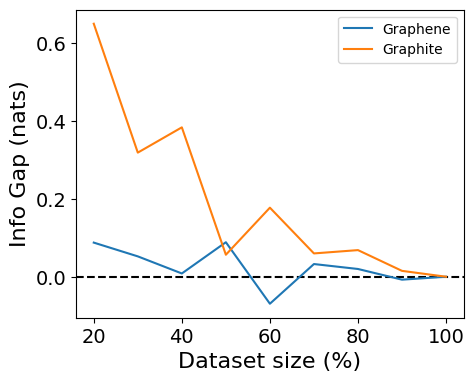

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.axhline(0.0, linestyle='--', c='k')
for system in ['Graphene', 'Graphite']:
    rows = infogap_df[infogap_df['system'] == system].sort_values(by='perc')

    ax.plot(rows['perc'], rows['dH'], label=system)

ax.legend()

ax.tick_params(axis='both', labelsize=14)

ax.set_ylabel("Info Gap (nats)", fontsize=16)
ax.set_xlabel("Dataset size (%)", fontsize=16)

plt.show()

# Overlap between test and reference sets for the GAP-20 carbon dataset (Fig 4a)

In [14]:
k, cutoff = 32, 5.0

overlap_df = []
for i, system_x in enumerate(['Graphene', 'Graphite', "Nanotubes"]):
    dset_x = read(f"{DATA_ROOT}/gap20/{system_x}.xyz", index=":")

    for j, system_y in tqdm(enumerate(['Graphene', 'Graphite', "Nanotubes"])):

        if system_x == system_y:
            overlap_df.append({
                "reference": system_x,
                "test": system_y,
                "dH": np.array([0.0]),
            })
            continue

        dset_y = read(f"{DATA_ROOT}/gap20/{system_y}.xyz", index=":")

        x = get_descriptors(dset_x, k=k, cutoff=cutoff)
        x = torch.tensor(x, device="cuda")
        y = get_descriptors(dset_y, k=k, cutoff=cutoff)
        y = torch.tensor(y, device="cuda")

        dH = delta_entropy(y, x, h=0.015).cpu().numpy()

        overlap_df.append({
            "reference": system_x,
            "test": system_y,
            "dH": dH,
        })

overlap_df = pd.DataFrame(overlap_df)

overlap_df['overlap_frac'] = overlap_df['dH'].apply(lambda x: (x < 1e-5).mean())

3it [00:15,  5.26s/it]
3it [00:11,  3.83s/it]
3it [00:15,  5.15s/it]


In [15]:
# Alternatively, if the execution is taking too long, just load it from the results
# overlap_df = pd.read_pickle("{DATA_ROOT}/results/overlap.pkl")

In [16]:
overlap_matrix = overlap_df.pivot(index="test", columns='reference', values='overlap_frac')

<Axes: xlabel='reference', ylabel='test'>

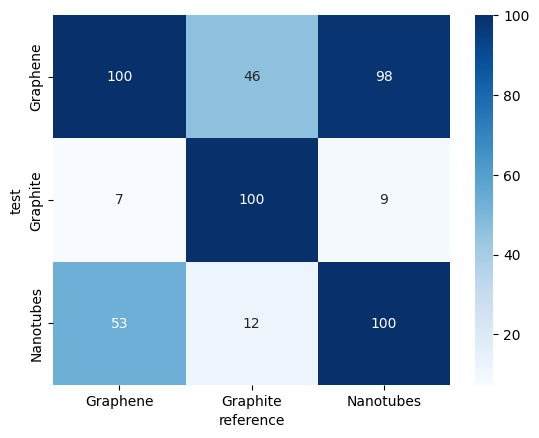

In [17]:
sns.heatmap(overlap_matrix * 100, cmap='Blues', annot=True, fmt=".0f")

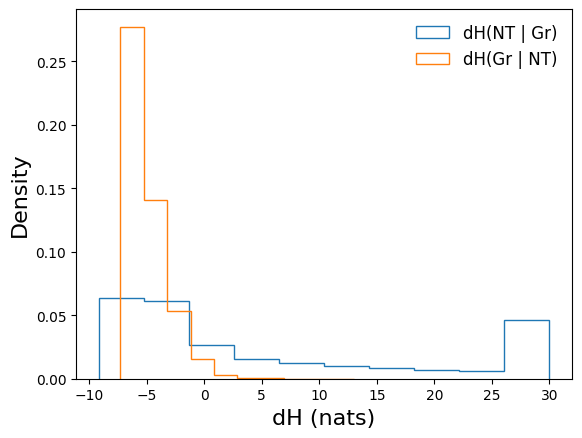

In [18]:
fig, ax = plt.subplots()

dH_NT_Gr = overlap_df[(overlap_df['test'] == 'Nanotubes') & (overlap_df['reference'] == "Graphene")]['dH'].values.item()
dH_Gr_NT = overlap_df[(overlap_df['test'] == 'Graphene') & (overlap_df['reference'] == "Nanotubes")]['dH'].values.item()

ax.hist(dH_NT_Gr.clip(max=30), histtype="step", label="dH(NT | Gr)", density=True)
ax.hist(dH_Gr_NT.clip(max=30), histtype="step", label="dH(Gr | NT)", density=True)

ax.set_ylabel("Density", fontsize=16)
ax.set_xlabel("dH (nats)", fontsize=16)

ax.legend(frameon=False, fontsize=12)
plt.show()